In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
import matplotlib.pyplot as plt
!pip install keras-tuner
import keras_tuner as kt


Reloading Tuner from tuning_dir/word_prediction/tuner0.json
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 789ms/step - accuracy: 0.0000e+00 - loss: 4.0261 - val_accuracy: 0.0000e+00 - val_loss: 4.0281
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.0569 - loss: 4.0183 - val_accuracy: 0.0000e+00 - val_loss: 4.0349
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0673 - loss: 4.0104 - val_accuracy: 0.0000e+00 - val_loss: 4.0442
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0673 - loss: 4.0005 - val_accuracy: 0.0000e+00 - val_loss: 4.0572
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0828 - loss: 3.9867 - val_accuracy: 0.0000e+00 - val_loss: 4.0759
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1037 - loss: 3.9635 - val_accuracy: 0.0000e+00 - val_loss: 4.1099
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0984 - loss: 3.9343 - val_accuracy: 0.0000e+00 - val_loss: 4.1722
Epoch 8/100
2/2 ━━━━━━━━━

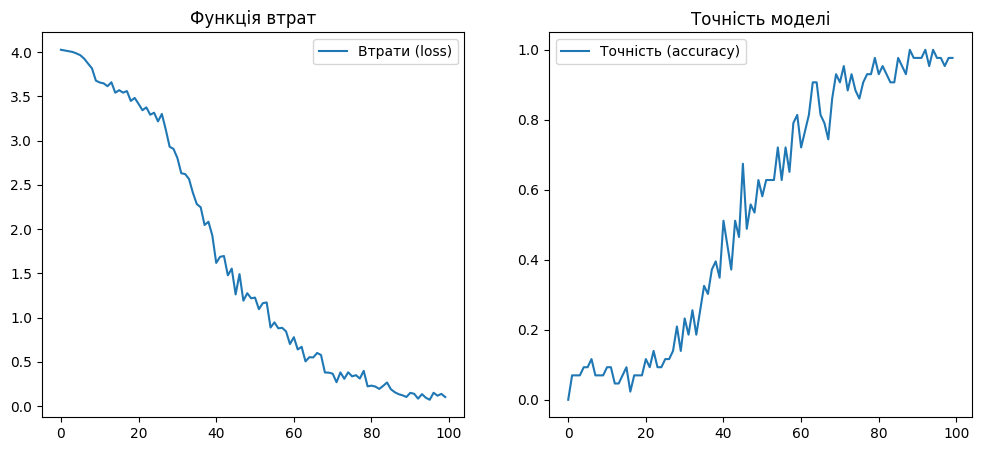

In [ ]:
# Текст для навчання
text = """Як дитиною, бувало,
Упаду собі на лихо,
То хоч в серце біль доходив,
Я собі вставала тихо.

"Що, болить?" – мене питали,
Але я не признавалась –
Я була малою горда, –
Щоб не плакать, я сміялась.

А тепер, коли для мене
Жартом злим кінчиться драма
І от-от зірватись має
Гостра, злобна епіграма, –

Безпощадній зброї сміху
Я боюся піддаватись,
І, забувши давню гордість,
Плачу я, щоб не сміятись."""

# Токенізація тексту
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

# Генерація послідовностей слів
input_sequences = []
for line in text.split("\n"):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])

# Доповнення послідовностей
max_seq_length = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre')

# Розділення вхідних значень
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = keras.utils.to_categorical(y, num_classes=total_words)

# Функція для підбору параметрів
def build_model(hp):
    model = Sequential()
    model.add(Embedding(total_words, hp.Choice('embedding_dim', [64, 128, 256]), input_length=max_seq_length-1))

    model.add(Bidirectional(LSTM(hp.Choice('lstm_units1', [128, 256, 512]), return_sequences=True)))
    model.add(Dropout(hp.Choice('dropout1', [0.2, 0.3, 0.4])))

    model.add(Bidirectional(LSTM(hp.Choice('lstm_units2', [128, 256, 512]))))
    model.add(Dropout(hp.Choice('dropout2', [0.2, 0.3, 0.4])))

    model.add(Dense(hp.Choice('dense_units', [128, 256, 512]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout3', [0.2, 0.3, 0.4])))

    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model, objective='accuracy', max_epochs=30, directory='tuning_dir', project_name='word_prediction')
tuner.search(X, y, epochs=30, validation_split=0.2)

# Вибір найкращої моделі
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)

# Навчання моделі
history = model.fit(X, y, epochs=100, validation_split=0.2, verbose=1)

# Побудова графіків
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Втрати (loss)')
plt.legend()
plt.title('Функція втрат')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Точність (accuracy)')
plt.legend()
plt.title('Точність моделі')

plt.show()